# Assignment - Image Classification

Applying active learning by collecting a few data point and going through the following approach:

1. Collect datapoints
2. Train a model
3. Evaluate the model
4. Actively clean existing data & collect new data
5. Repeat (2-4) until wanted accuracy is reached

## 1. Load data


The images can be found in Google Drive in the required folder structure

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [38]:
from fastbook import *
from fastai.vision.widgets import *

In [39]:
path = Path("/content/drive/MyDrive/Informatics/Project B - Book Cover/book-covers")
path.exists()

True

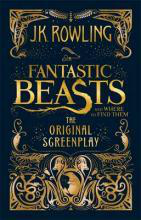

In [40]:
# Display one of the images
a_image = Image.open(path/"Art-Photography/0000001.jpg")
a_image.to_thumb(250, 250)

In [41]:
# Getting a list of path objects where to find the images
fns = get_image_files(path)
fns

Path('/content/drive/MyDrive/Informatics/Project B - Book Cover/book-covers/Graphic-Novels-Anime-Manga/0000951.jpg')

In [ ]:
# Check the images if they have the right extension, etc
failed = verify_images(fns)
failed

In [ ]:
# There were no failed messages, so this isn't necessary to be run
failed.map(Path.unlink)

(#0) []

### Preprocessing
* So far we have a list of path objects pointing to images.
* We still need to have the data in a specific way to present it to a neural network.

In [43]:
books = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # independent_vars: Images, dependent_var: category
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # validation set is 20%
    get_y=parent_label,
    item_tfms=Resize(256)
)

In [44]:
# Combining the dls object with the path where our data is
dls = books.dataloaders(path)

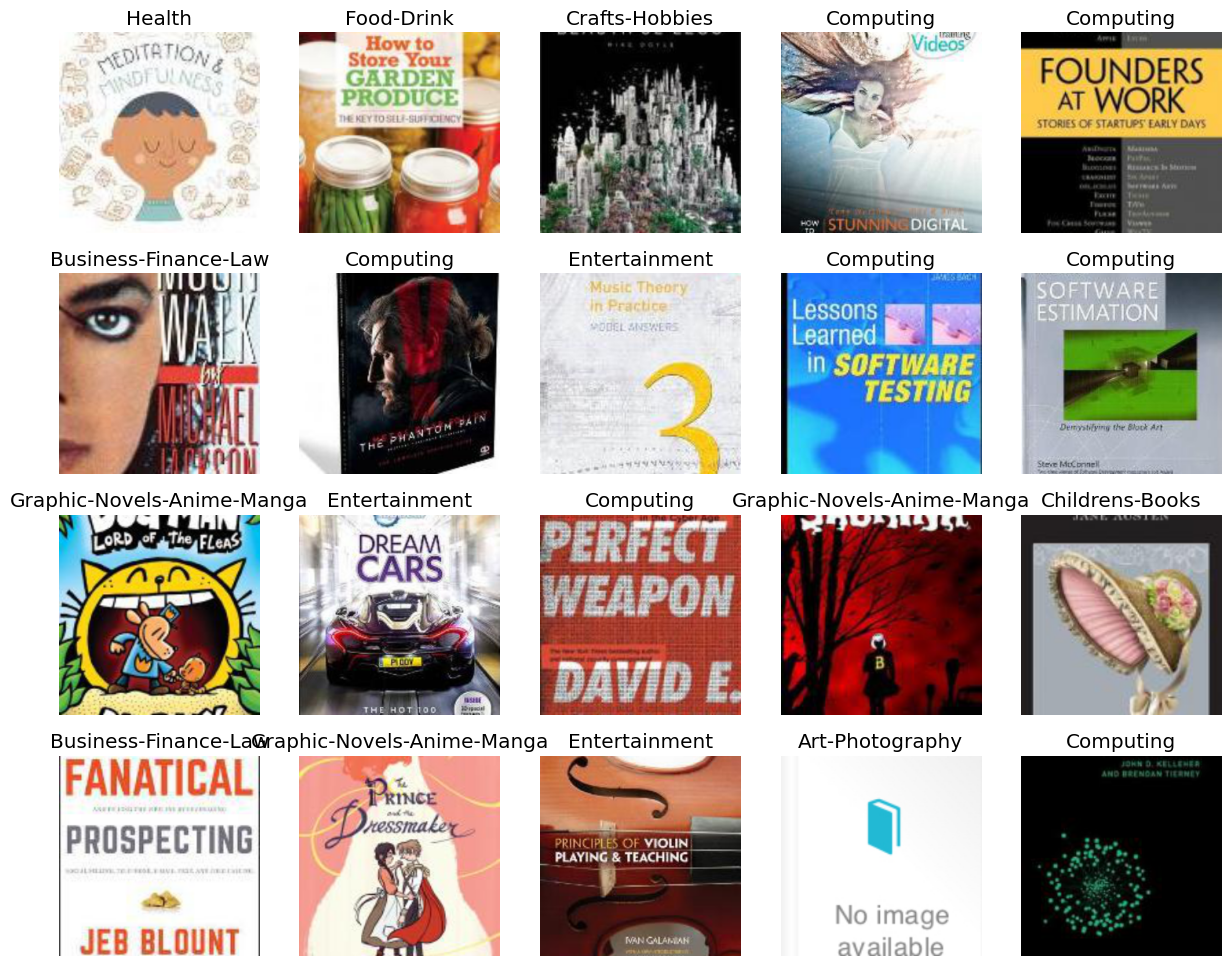

In [45]:
# Showing 20% of validation data that the dls object has now
dls.valid.show_batch(max_n=20, nrows=4)

### Data Augmentation
* Modifying the same image (e.g. shifting, rotating, etc) in a way that we get a new image
* So we can get a lot more out of our data like this

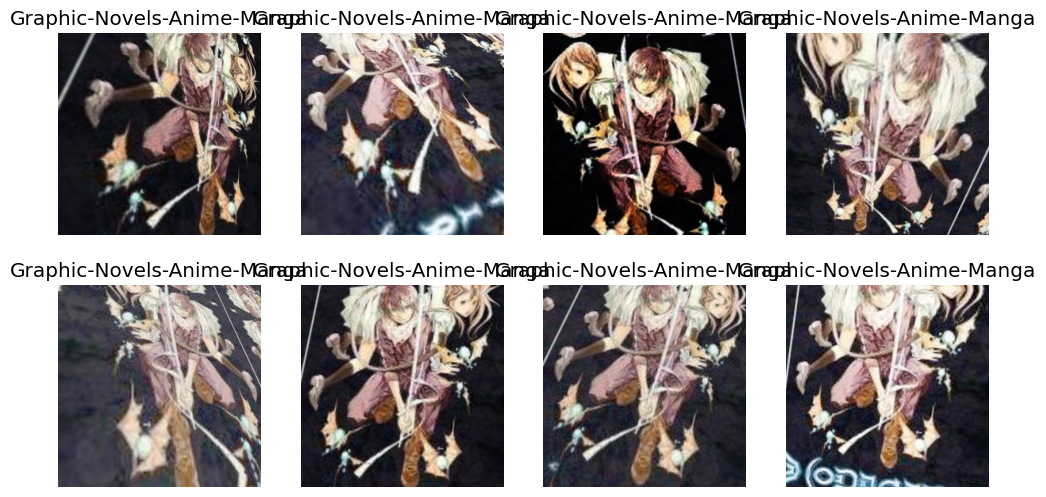

In [46]:
books = books.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = books.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## 2. Train the Model

In [47]:
books = books.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # item transformation
    batch_tfms=aug_transforms() # data augmentation
)
dls = books.dataloaders(path) # connect our data block (where we added some batch transform) with the path

In [48]:
# Using resnet18 as neural network architecture
learn = cnn_learner(dls, resnet18, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fine tuning
* Cutting the last few layers of resnet18 away and retraining those
* So the most high level layers are thrown away and are replaced by our own layers

In [49]:
learn.fine_tune(2) # 4 is the amount of epochs

We got **39% accuracy** on the validation set

## 3. Evaluate the Model
Since we have a classification problem we first look at the confusion matrix.

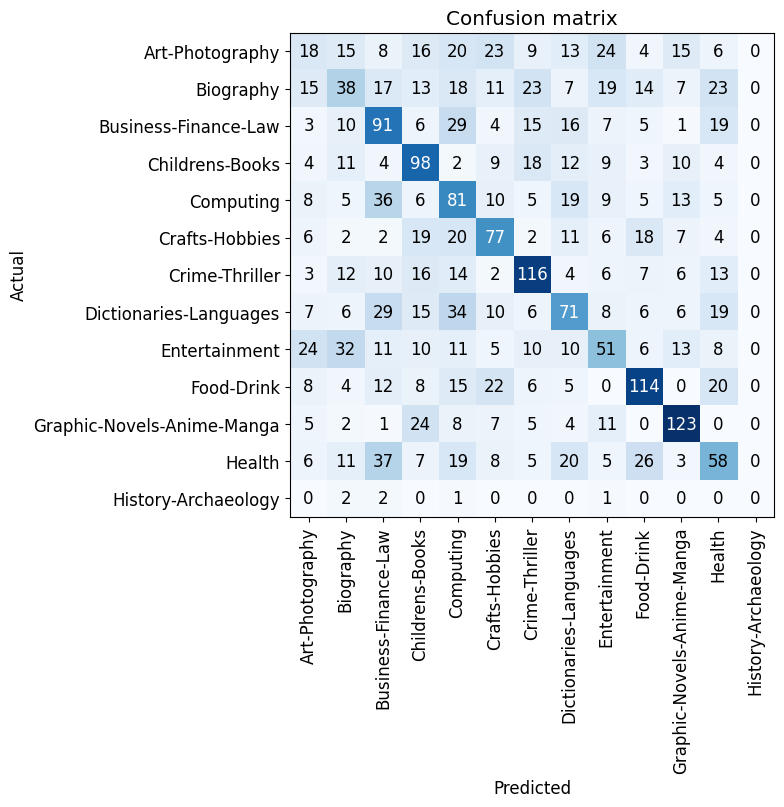

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 8))

Top 5 most confidently misclassified books:

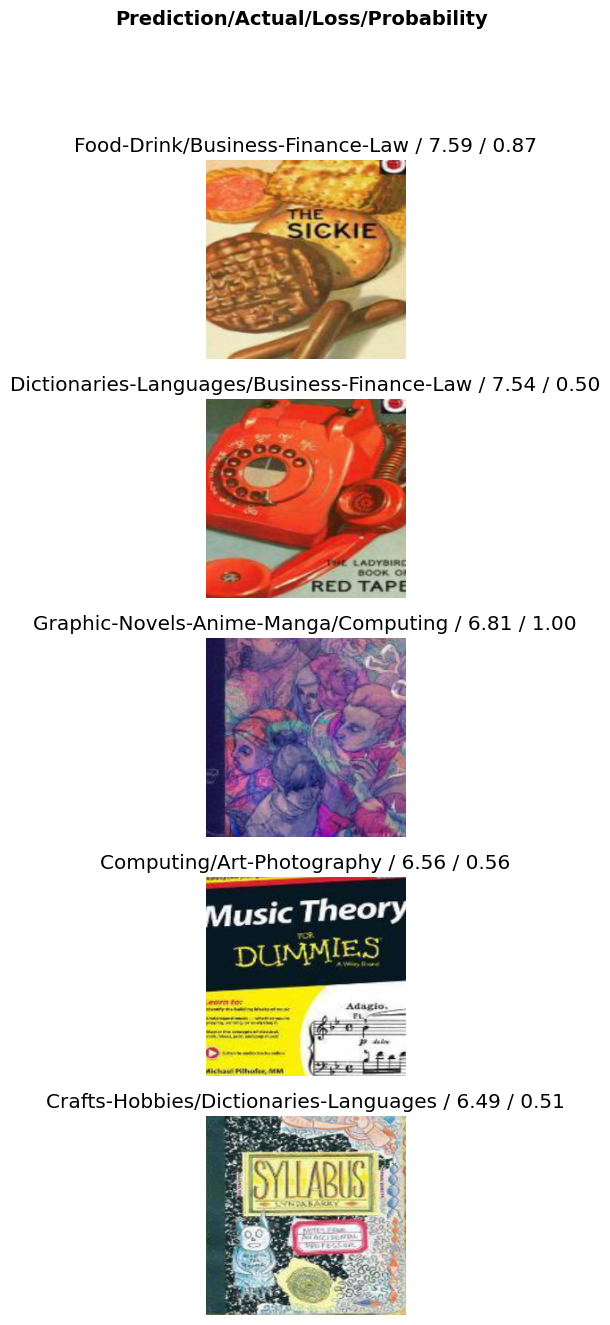

In [56]:
interp.plot_top_losses(5, nrows=5)

## 4 Actively clean data

As we have also seen above, there are pictures where the model is obviously confused. So as we are following the data centric approach, now we would have to look at the data and identify which were the images misclassified and remove those or assign them a new category.

In [57]:
cleaner = ImageClassifierCleaner(learn)
cleaner